**Making a script to input .mca or .spe files to and output some lovely spectrum**

In [96]:
#%%writefile spectrum_reader.py
"""
spectrum_reader.py

This will read in spe or mca files from our detectors and make us some lovely background subtracted spectra


"""
import numpy as np
import os
import matplotlib.pyplot as plt
import scipy
from scipy.optimize import curve_fit
import pandas as pd

from glob import glob
from lmfit.models import LinearModel

def file_type_checker(filename):
    """checks the file type, because the header will have diff formatting"""
    
    if filename[-3:] == "Spe":
        return "Spe"
    elif filename[-3:] == "mca":
        return "mca"
    else: return "error"

def file_parser(filename):

    #the function will fill and return these dictionaries:
    
    header_dict = {
        "DATE_MEAS": [],
        "MEAS_TIME": []
    }

    spectrum_dict = {
        "bins": [], 
        "counts": []
    }

    if file_type_checker(filename) == "Spe" :
        IS_DATA = False

        with open(filename, "r") as file:
            for line in file:
                line = line.strip()

            # if it's data, reset the flag
                if line == '$DATA:':
                    IS_DATA = True
                    continue
                elif line.startswith('$MEAS_TIM:'):
                    next_line = next(file).split(" ")
                    header_dict["MEAS_TIME"].append(float(next_line[0]))
                    IS_DATA = False
                elif line.startswith('$DATE_MEA:'):
                    next_line = next(file).strip()
                    header_dict["DATE_MEAS"].append(next_line)
                    IS_DATA = False

            #this is for all lines following # DATA
            #while IS_DATA == True:  
                if IS_DATA == True:
                    try:
                        spectrum_dict["counts"].append(float(line))
                    except ValueError:
                        continue   
        #change if bin range changes
        for i in range(len(spectrum_dict["counts"])):
            spectrum_dict["bins"].append(i)
        
        return header_dict, spectrum_dict

    elif  file_type_checker(filename) == "mca" :
        IS_DATA = False

        with open(filename, "r") as file:
            for line in file:
                line = line.strip()
    
                # if it's data, reset the flag
                if line.startswith('<<DATA>>'):
                    IS_DATA = True
                    continue
                elif line.startswith('REAL_TIME'):
                    line = line.strip()
                    header_dict["MEAS_TIME"].append(float(line[12:]))
                    IS_DATA = False
                elif line.startswith('START_TIME'):
                    line = line.strip()
                    header_dict["DATE_MEAS"].append(line[13:])
                    IS_DATA = False
                elif line.startswith("<<END>>"):
                    IS_DATA = False
                # else:
                #     print('hang on a sec')
                #     print(line)
    
                #this is for all lines following # DATA
                #while IS_DATA == True:  
                if IS_DATA == True:
                    try:
                        spectrum_dict["counts"].append(int(line))
                    except Exception as e:
                        print(e)
                        continue   
        #change if bin range changes
        for i in range(len(spectrum_dict["counts"])):
            spectrum_dict["bins"].append(i)
        
        return header_dict, spectrum_dict

    elif file_type_checker(filename) == "error":
        print("give me the right file type (mca or spe) pretty please!")

def background_subtract(data, background):
    """
    Converts spectrum to units of counts/sec then subtracts background from data
    Inputs: data file, backgound file (.spe or .mca files)
    Outputs: returns dataframe object of bins and counts per second of background subtracted spectra and plot of bins by counts/sec
    """
    data_header, data_spectrum = file_parser(data)
    background_header, background_spectrum = file_parser(background)

    background_ct = background_header["MEAS_TIME"]
    data_ct = data_header["MEAS_TIME"]

    background_subtracted = (np.array(data_spectrum["counts"]) / data_ct) - (np.array(background_spectrum["counts"]) / background_ct)

    table = {
        'bins' : data_spectrum["bins"],
        'counts/sec' : background_subtracted
    }

    plt.close("all")
    fig, ax = plt.subplots(figsize = (8,8))
    ax.set_title(f"background subtracted spectra from: {data}")
    ax.set_xlabel("bins")
    ax.set_ylabel("counts / sec")
    ax.scatter(table["bins"], table["counts/sec"], s = 1, label = "Spectrum")

    ax.legend()
    plt.show()
    
    return pd.DataFrame(table)

def peak_finder(table):
    """finds peaks in data"""

    max_point = np.argmax(table["counts/sec"][10:]) #ignores the first ten bins incase of weird detector noise
    
    return int(max_point)

def ignore_peak(flux):
    """
    Function used to ignore the peak part of the data for plotting the baseline
    Input: y data (flux)
    Output: list of ajdusted y data, were values associated with the peak are replaced with mean flux
    """
    background_y = []
    mean_flux = np.mean(flux)
    flux_std = np.std(flux)
    for i in flux:
        if i < (0.5 * flux_std):
            background_y.append(i)
            background_mean = np.mean(background_y) #make a mean background level
        elif background_y == []:
            background_y.append(mean_flux)
        else:
            background_mean = np.mean(background_y)
            background_y.append(background_mean)
       # if i > 0.5 * (flux_std): #if the flux is higher than this, the point is probably part of the peak
      #      background_y.append(mean_flux) 
       #else:
        #    background_y.append(i)
    return background_y

#fitting functions: 
def quadratic(x, a, b, c):
    """A quatratic function, used for curve fitting"""
    return a * (x**2) + b * x + c

def gaussian(x, mu, sig, amp):
    """A Gaussian function, used for scipi curve fit"""
    return amp * np.exp(-0.5 * (x-mu)**2 / sig**2) / np.sqrt(2 * np.pi * sig**2)

def compound_model(x, mu, sig, amp, a, b, c):
    """combines the quadratic fit of the background with the Gaussian fit which better represents the peak"""
    return quadratic(x, a, b, c) + gaussian(x, mu, sig, amp)

def fit_compound_model(x, y, p0=None):
    """
    Function to fit data using curve_fit and compound_model
    Inputs: x, y (list of x, y data)
    Outputs: popt (parameters array), pcov (covarience array) 
    """

    #if no p0 is passed, guess: 

    if p0 is None: 
        A_guess = np.max(y) - np.min(y)
        mu_guess = np.sum(x * y) / np.sum(y)
        sigma_guess = (np.max(x) - np.min(x)) / 10
        #getting the polynomial parameters: 
        background_y = ignore_peak(y)
        b_popt, b_pcov = curve_fit(quadratic, x, background_y, p0 = None)

    p0 = [mu_guess, sigma_guess, A_guess, *b_popt]
    popt, pcov = curve_fit(compound_model, x, y, p0 = p0)

    return popt, pcov

def print_uncertainties(pcov, popt):
    """a function to print out the parameters and their uncertanties"""
    uncertainties = np.sqrt(np.diag(pcov))
    #[mu0, sig0, amp0, a, b, c] 
    print("Parameters: \n")
    print(f"Baseline Polynomial Fit: ")
    print(f"a = {popt[3]} +/- {uncertainties[3]},")
    print(f"b = {popt[4]} +/- {uncertainties[4]}, ")
    print(f"c = {popt[5]} +/- {uncertainties[5]}")
    print(f"Gaussian Fit: ")
    print(f"mu0 = {popt[0]} +/- {uncertainties[0]},")
    print(f"sigma0 = {popt[1]} +/- {uncertainties[1]},")
    print(f"amp0 = {popt[2]} +/- {uncertainties[2]}")

def gauss_fitter(table, peak_range):
    """
    Function to fit a gaussian to data and find the location of peaks
    Input: table of bins and counts/sec for a spectrum and a range of interest to look for peaks in
    Output: mu0 (popt[0] from the curve fit of a found peak), and some plots
    """
    
    
    background_y = ignore_peak(table["counts/sec"][peak_range])
    b_popt, b_pcov = curve_fit(quadratic, table["bins"][peak_range], background_y, p0 = None)
    quad_fit = quadratic(np.array(table["bins"][peak_range]), *b_popt)

    #plotting data with polynomial baseline fit overlaid:
    plt.close("all")
    fig, ax = plt.subplots(figsize  = (9,6))
    ax.set_title("Spectrum Data Plotted With Baseline Fitted")
    ax.set_xlabel("bins")
    ax.set_ylabel("counts per second")
    
    ax.plot(table["bins"][peak_range], table["counts/sec"][peak_range], ls = ":", label = "data")
    ax.plot(table["bins"][peak_range], quad_fit, ls = '--', label = "fit")
    ax.grid()
    ax.legend()
    plt.show()

    #fitting and plotting gauss model: 
    popt, pcov = fit_compound_model(np.array(table["bins"][peak_range]), np.array(table["counts/sec"][peak_range]))
    #compound_fit = compound_model(np.array(spectrum_dict["Wavelength"]), *popt)
    gauss_fit = gaussian(np.array(table["bins"][peak_range]), *popt[:3])
        
    fig, ax = plt.subplots(figsize = (9,6))
    
    ax.set_title("Spectrum Data Plotted With Gaussian Fit: Second Peak from the Left")
    ax.set_xlabel("bins")
    ax.set_ylabel("counts per second")
    
    ax.plot(table["bins"][peak_range], table["counts/sec"][peak_range], ls = ":", label = "data")
    ax.plot(table["bins"][peak_range], quad_fit, ls = '--', label = "baseline fit")
    #for some reason the line below works better than plotting compound model even though it should return the same thing?
    ax.plot(table["bins"][peak_range], gauss_fit + quad_fit, ls = '-', color = 'r', label = "gaussian fit") 
    ax.grid()
    ax.legend()
    plt.show()
    
    #printing out parameters and uncertainties:
    print_uncertainties(pcov, popt)

    
    #returning peak location, sigma, and amplitude: 
    return popt[0], popt[1], popt[2]

def subtract_and_fit(data, background, peak_range):
    """
    Function to subtract background from a sepctrum then fit a peak within a given range
    Outputs: peak location, sigma0, and amplitude from the fit. 
    """
    bg_sub_table = background_subtract(data, background)
    mu0, sigma, amp = gauss_fitter(bg_sub_table, peak_range)

    return mu0, sigma, amp

def make_results_dict(filepath, background, detector):
    """
    Funtion to take in a path to all the spectrum readings we'll use from a given detector, parse them, fit to specific ranges for peaks 
    for a given source in the file name, and append fit results to a dictionary for use characterizing the detector
    Inputs: path to files, config file? (RIGHT NOW I AM HARDCODING THAT PART), detector input as string
    Outputs: a pandas data frame

    this is the stupidest function I;ve ever made and atm it entirely relies on having the same naming convention for all files
    """
    #dictionary of results to fill
    results = {
        'energy' : [],
        'peak loc' : [],
        'FWHM' : [],
        'amp' : []
    }

    
    if detector == "NaITi":
        #THIS IS HARDCODED RN AND SHOULD BE FROM CONFIG FILE
        energies = { 
            #'Co' : [1173.228, 1332.492],  Co NOT USED FOR THIS DETECTOR THE PEAKS SUCK
            'Cs' : [661.657],
            'Ba' : [80.9979, 356.0129],
            'Am' : [59.5409]
        }
    
        ranges = {
            'Cs' : [range(225, 400)],
            'Ba' : [range(22, 85), range(90,200)],
            'Am' : [range(0,60)]
        }

        datafiles = glob(filepath + '*.Spe')

        for file in datafiles:
            if 'Cs' in file:
                mu, sig, amp = subtract_and_fit(file, background, ranges['Cs'][0])
                results['energy'].append(energies['Cs'][0])
                results['peak loc'].append(mu)
                results['FWHM'].append(2.355 * sig)
                results['amp'].append(amp)
            elif 'Ba' in file:
                mu0, sig0, amp0 = subtract_and_fit(file, background, ranges['Ba'][0])
                results['energy'].append(energies['Ba'][0])
                results['peak loc'].append(mu0)
                results['FWHM'].append(2.355 * sig0)
                results['amp'].append(amp0)
                
                mu1, sig1, amp1 = subtract_and_fit(file, background, ranges['Ba'][1])
                results['energy'].append(energies['Ba'][1])
                results['peak loc'].append(mu1)
                results['FWHM'].append(2.355 * sig1)
                results['amp'].append(amp1)
            elif 'Am' in file: 
                mu, sig, amp = subtract_and_fit(file, background, ranges['Am'][0])
                results['energy'].append(energies['Am'][0])
                results['peak loc'].append(mu)
                results['FWHM'].append(2.355 * sig)
                results['amp'].append(amp)

    elif detector == "BGO":
        energies = { 
            'Co' : [1173.228],
            'Cs' : [661.657],
            'Ba' : [80.9979, 356.0129],
            'Am' : [59.5409]
        }

        ranges = {
            'Co' : [range(470, 600)],
            'Cs' : [range(210, 350)],
            'Ba' : [range(20, 50), range(100,200)],
            'Am' : [range(0,60)]
        }

        datafiles = glob(filepath + '*.Spe')
        
        for file in datafiles:
            if 'Co' in file:
                mu, sig, amp = subtract_and_fit(file, background, ranges['Co'][0])
                results['energy'].append(energies['Co'][0])
                results['peak loc'].append(mu)
                results['FWHM'].append(2.355 * sig)
                results['amp'].append(amp)
            elif 'Cs' in file:
                mu, sig, amp = subtract_and_fit(file, background, ranges['Cs'][0])
                results['energy'].append(energies['Cs'][0])
                results['peak loc'].append(mu)
                results['FWHM'].append(2.355 * sig)
                results['amp'].append(amp)
            elif 'Ba' in file:
                mu0, sig0, amp0 = subtract_and_fit(file, background, ranges['Ba'][0])
                results['energy'].append(energies['Ba'][0])
                results['peak loc'].append(mu0)
                results['FWHM'].append(2.355 * sig0)
                results['amp'].append(amp0)
                
                mu1, sig1, amp1 = subtract_and_fit(file, background, ranges['Ba'][1])
                results['energy'].append(energies['Ba'][1])
                results['peak loc'].append(mu1)
                results['FWHM'].append(2.355 * sig1)
                results['amp'].append(amp1)
            elif 'Am' in file: 
                mu, sig, amp = subtract_and_fit(file, background, ranges['Am'][0])
                results['energy'].append(energies['Am'][0])
                results['peak loc'].append(mu)
                results['FWHM'].append(2.355 * sig)
                results['amp'].append(amp)
        
    elif detector == "CdTe":
        energies = { 
            'Co' : [1173.228],
            'Cs' : [661.657],
            'Ba' : [80.9979, 356.0129],
            'Am' : [59.5409]
        }

        ranges = {
            'Co' : [range(470, 600)],
            'Cs' : [range(200, 250)],
            'Ba' : [range(200, 300), range(500,600)],
            'Am' : [range(380, 500)]
        }

        datafiles = glob(filepath + '*.mca')
        
        for file in datafiles:
            #if 'Co' in file:
            #    mu, sig, amp = subtract_and_fit(file, background, ranges['Co'][0])
            #    results['energy'].append(energies['Co'][0])
             #   results['peak loc'].append(mu)
             #   results['FWHM'].append(2.355 * sig)
            #    results['amp'].append(amp)
            if 'Cs' in file:
                mu, sig, amp = subtract_and_fit(file, background, ranges['Cs'][0])
                results['energy'].append(energies['Cs'][0])
                results['peak loc'].append(mu)
                results['FWHM'].append(2.355 * sig)
                results['amp'].append(amp)
            elif 'Ba' in file:
                mu0, sig0, amp0 = subtract_and_fit(file, background, ranges['Ba'][0])
                results['energy'].append(energies['Ba'][0])
                results['peak loc'].append(mu0)
                results['FWHM'].append(2.355 * sig0)
                results['amp'].append(amp0)
                
                mu1, sig1, amp1 = subtract_and_fit(file, background, ranges['Ba'][1])
                results['energy'].append(energies['Ba'][1])
                results['peak loc'].append(mu1)
                results['FWHM'].append(2.355 * sig1)
                results['amp'].append(amp1)
            elif 'Am' in file: 
                mu, sig, amp = subtract_and_fit(file, background, ranges['Am'][0])
                results['energy'].append(energies['Am'][0])
                results['peak loc'].append(mu)
                results['FWHM'].append(2.355 * sig)
                results['amp'].append(amp)

    else: 
        print("Spell the Name of the Detector Right PLease: NaITi, BGO, or CdTe.")
    
    return pd.DataFrame(results)

def line(x, m, b):
    """linear fucntion to use in fitting"""
    return m * x + b                   

def linear_fit(x_data, y_data, model):
    """Function to fit a line to points using curve_fit"""
    popt, pcov = curve_fit(model, x_data, y_data)
    return popt


def fit_energies(dictionary):
    """
    Function to fit energies to channel numbers
    Input: dictionary of results from make_results_dict
    Output: slope and intercept of channel-energy relation line
    """
    
    popt = linear_fit(dictionary['peak loc'], dictionary['energy'], line)
    fit_line = line(dictionary['peak loc'], popt[0], popt[1])

    plt.close("all")
    fig, ax = plt.subplots(figsize = (8, 8))
    
    ax.set_title("NaITi Detector peak energy by channel number")
    ax.set_xlabel("Channel Number")
    ax.set_ylabel("Energy (keV)")
    ax.scatter(dictionary['peak loc'], dictionary['energy'], label = "data")
    ax.plot(dictionary['peak loc'], fit_line, ls = ":", label = "fit line")
    ax.legend()
    plt.show()
    
    print(f"Slope: {popt[0]} and Intercept: {popt[1]}")

    return popt[0], popt[1]

**TESTING: using file path with naming conventions for files that will work**

In [43]:
filepath = glob("experimental_NaI/" + "*.Spe")
filepath

['experimental_NaI\\Am_0degree.Spe',
 'experimental_NaI\\Ba_0degree.Spe',
 'experimental_NaI\\Buffer_Data.Spe',
 'experimental_NaI\\Co_0degree.Spe',
 'experimental_NaI\\Cs_0degree.Spe',
 'experimental_NaI\\Sample_1_Hg_0degree.Spe',
 'experimental_NaI\\Sample_1_Hg_90degree.Spe']

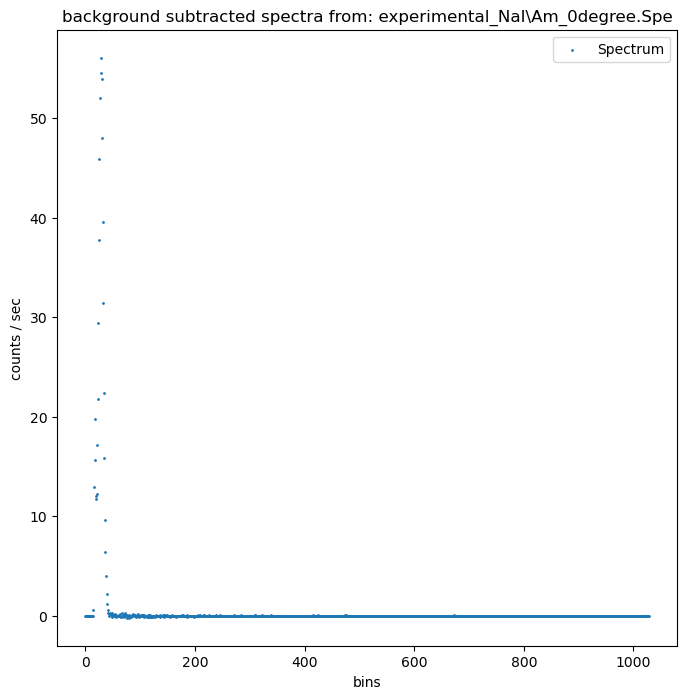

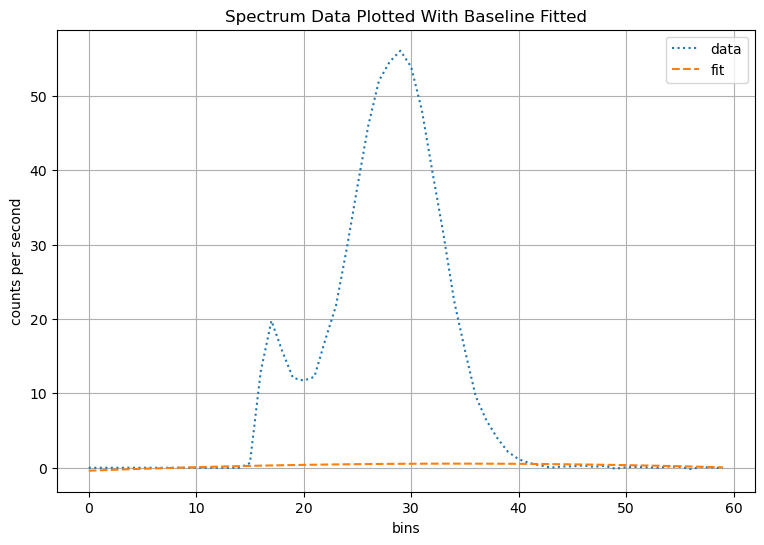

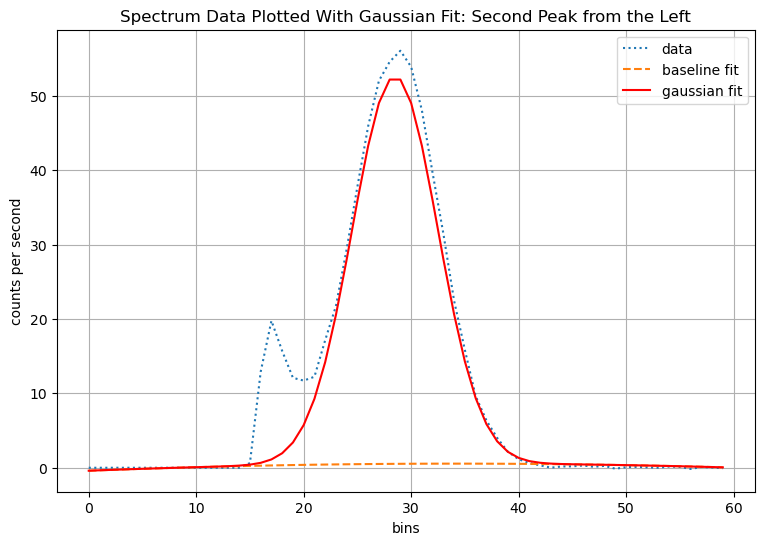

Parameters: 

Baseline Polynomial Fit: 
a = -0.005713055696080872 +/- 0.00238831960753251,
b = 0.29681221410412645 +/- 0.14222195088646286, 
c = -0.12365750464204726 +/- 1.3713802603407736
Gaussian Fit: 
mu0 = 28.496875839808183 +/- 0.1408322037442173,
sigma0 = -3.982454241293693 +/- 0.17793466301049743,
amp0 = 519.8545818412216 +/- 28.336528941677862


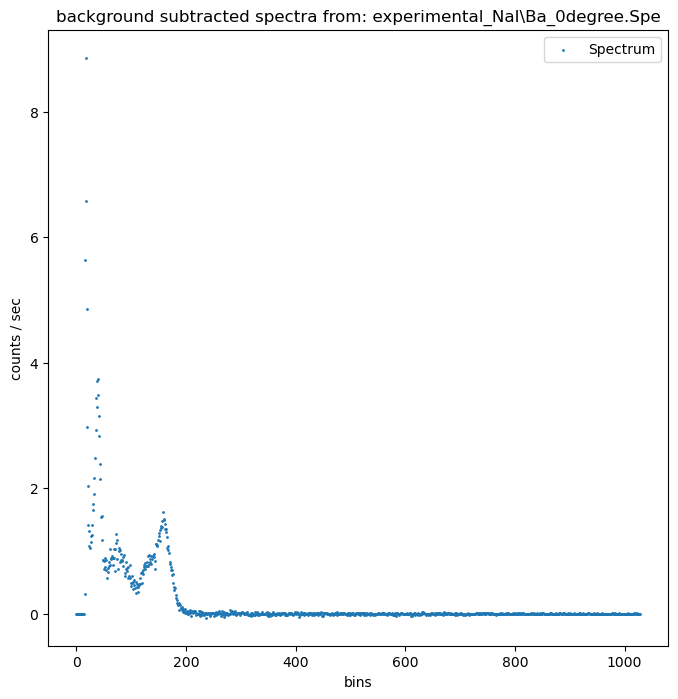

C:\Users\Bruce Ritter\AppData\Local\Temp\ipykernel_27460\1960483732.py:236: OptimizeWarning: Covariance of the parameters could not be estimated
  b_popt, b_pcov = curve_fit(quadratic, table["bins"][peak_range], background_y, p0 = None)


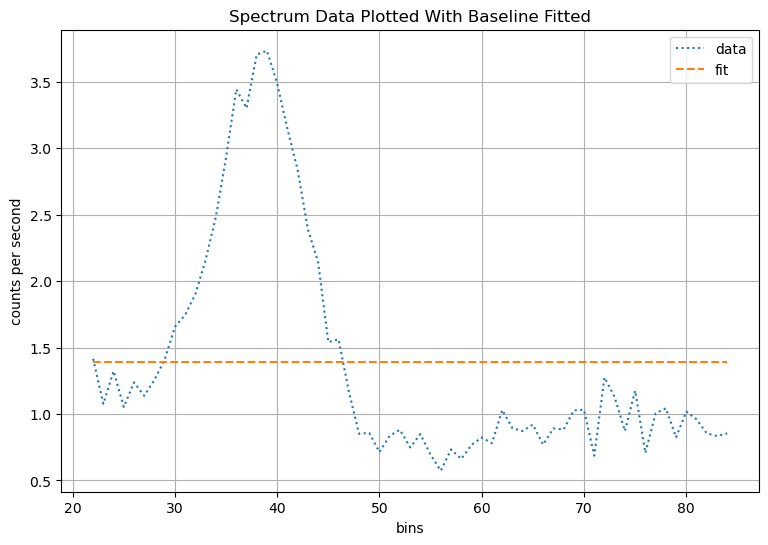

C:\Users\Bruce Ritter\AppData\Local\Temp\ipykernel_27460\1960483732.py:206: OptimizeWarning: Covariance of the parameters could not be estimated
  b_popt, b_pcov = curve_fit(quadratic, x, background_y, p0 = None)
C:\Users\Bruce Ritter\AppData\Local\Temp\ipykernel_27460\1960483732.py:209: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(compound_model, x, y, p0 = p0)


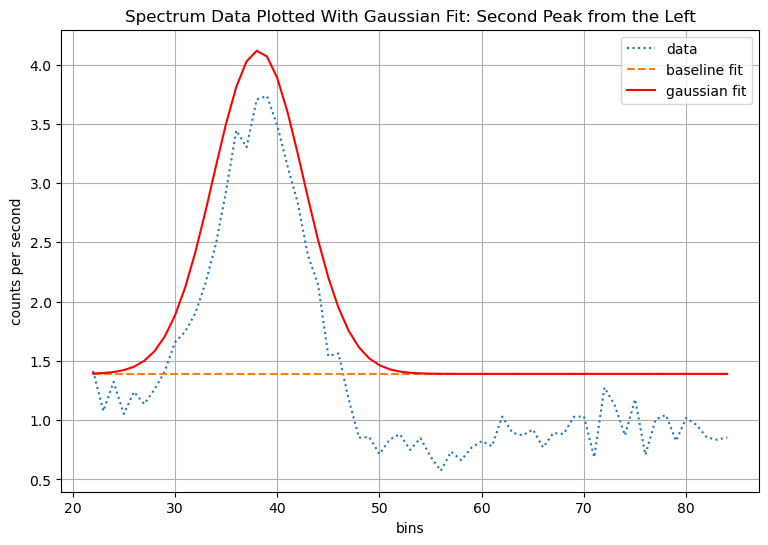

Parameters: 

Baseline Polynomial Fit: 
a = 2.220446049250313e-16 +/- inf,
b = -2.042810365310288e-14 +/- inf, 
c = 0.9128261081097551 +/- inf
Gaussian Fit: 
mu0 = 38.15162244158822 +/- inf,
sigma0 = 4.401765029609347 +/- inf,
amp0 = 30.094664817603096 +/- inf


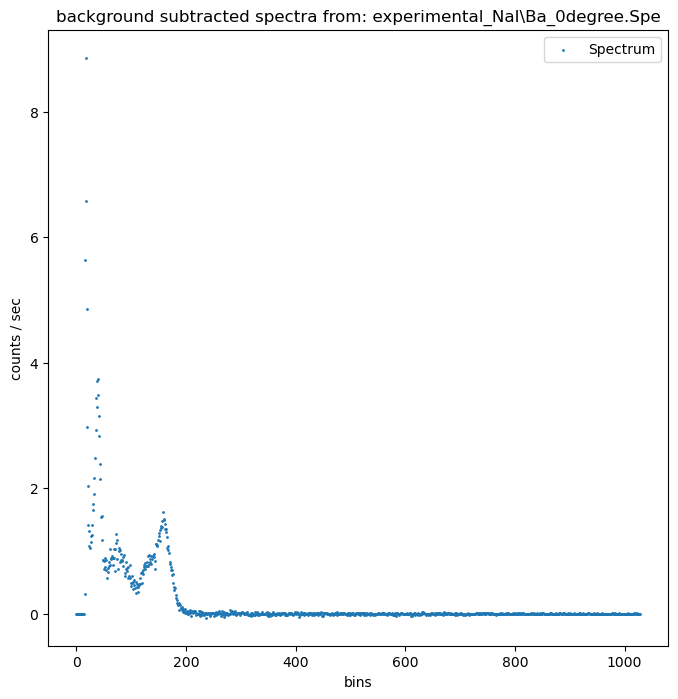

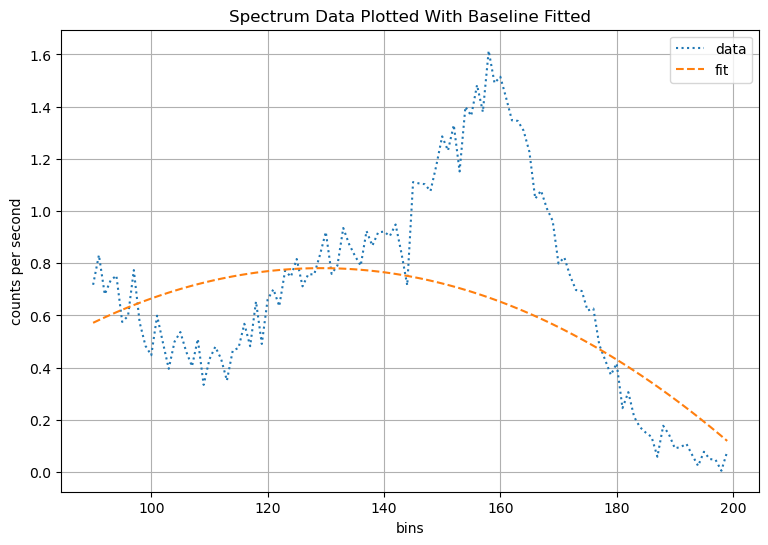

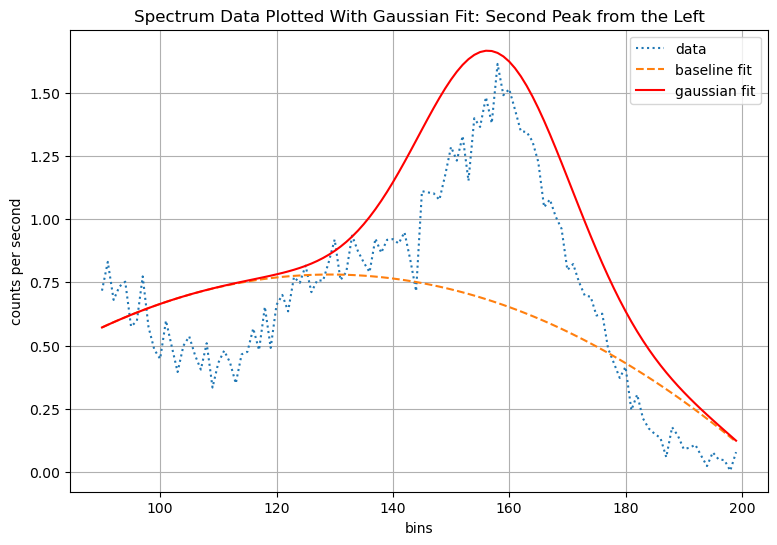

Parameters: 

Baseline Polynomial Fit: 
a = -7.806572812907464e-05 +/- 2.2141863886480814e-05,
b = 0.01685326951024892 +/- 0.006633631007817864, 
c = -0.3116376706455153 +/- 0.4548061125075484
Gaussian Fit: 
mu0 = 157.52791279683282 +/- 0.5233383586706896,
sigma0 = -12.672511202610856 +/- 0.7596397935044721,
amp0 = 31.45339649196012 +/- 2.938749278026072


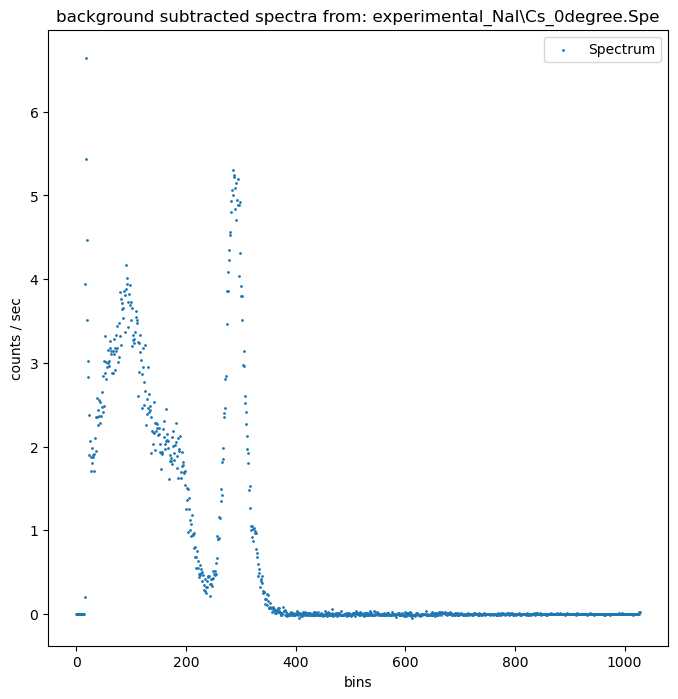

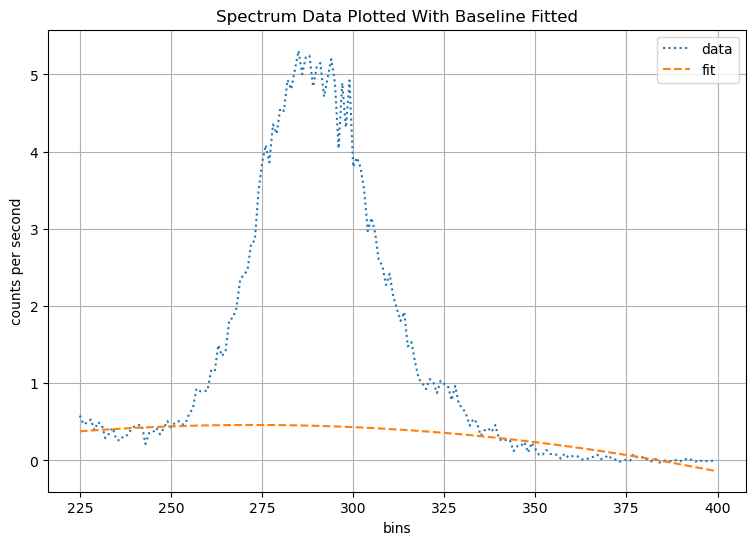

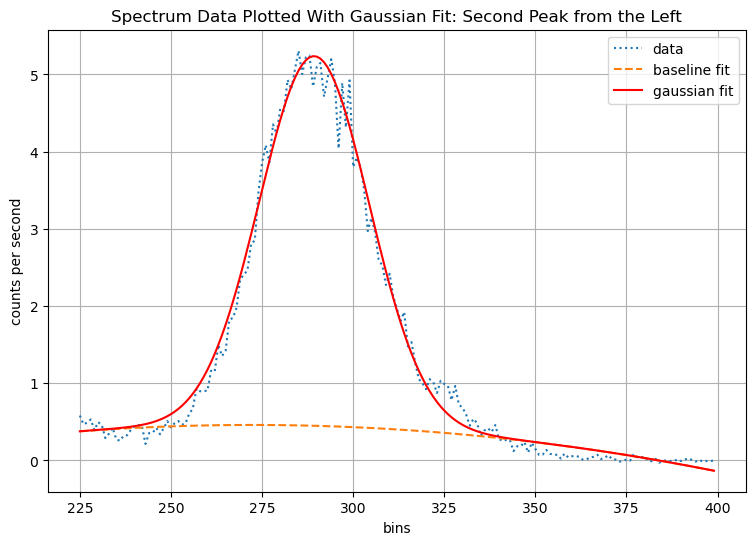

Parameters: 

Baseline Polynomial Fit: 
a = -3.782265940716725e-05 +/- 7.925140747258066e-06,
b = 0.021182347421761654 +/- 0.0048635845025289315, 
c = -2.5512189958383757 +/- 0.7179188164563567
Gaussian Fit: 
mu0 = 289.3165396009793 +/- 0.1565933452653613,
sigma0 = 15.059982605204029 +/- 0.1986877730562182,
amp0 = 180.72601949280315 +/- 3.0891991402713534


In [48]:
dictionary = make_results_dict("experimental_NaI/", "experimental_NaI/Buffer_Data.Spe", "NaITi")

In [49]:
dictionary

,energy,peak loc,FWHM,amp
0,59.5409,28.496876,-9.378680,519.854582
1,80.9979,38.151622,10.366157,30.094665
2,356.0129,157.527913,-29.843764,31.453396
3,661.6570,289.316540,35.466259,180.726019


**ok slay it works maybe**
now to plot peack loc (channel) by energy and also peak FWHM by energy (tho some r negative and some arent, fuck)

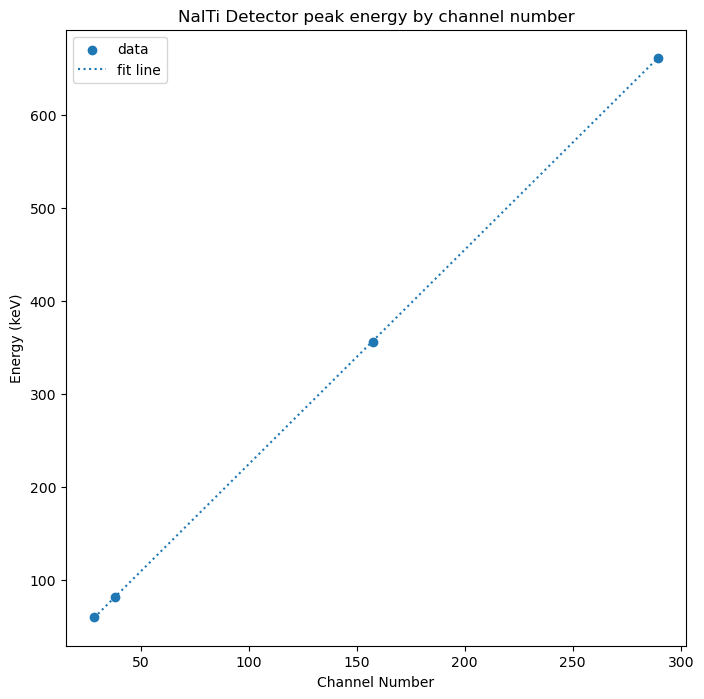

Slope: 2.3093136412780226 and Intercept: -6.901893925899741


In [88]:
slope, intercept = fit_energies(dictionary)

In [64]:
dictionary["FWHM (keV)"] = line(dictionary["FWHM"], slope, intercept)

In [65]:
dictionary

,energy,peak loc,FWHM,amp,FWHM (keV)
0,59.5409,28.496876,-9.378680,519.854582,-28.560207
1,80.9979,38.151622,10.366157,30.094665,17.036813
2,356.0129,157.527913,-29.843764,31.453396,-75.820505
3,661.6570,289.316540,35.466259,180.726019,75.000822


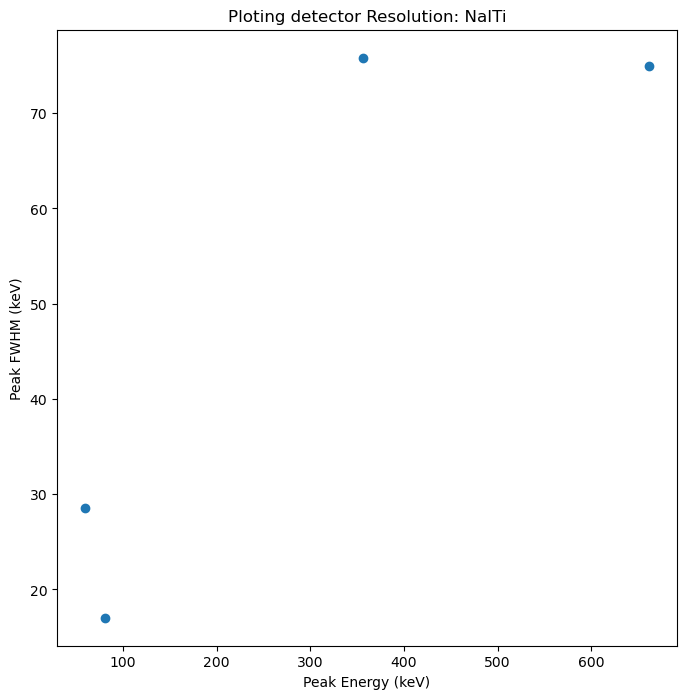

In [83]:
plt.close("all")
fig, ax = plt.subplots(figsize = (8,8))
ax.set_title("Ploting detector Resolution: NaITi")
ax.set_xlabel("Peak Energy (keV)")
ax.set_ylabel("Peak FWHM (keV)")

ax.scatter(dictionary["energy"], np.abs(dictionary["FWHM (keV)"]))

plt.show()

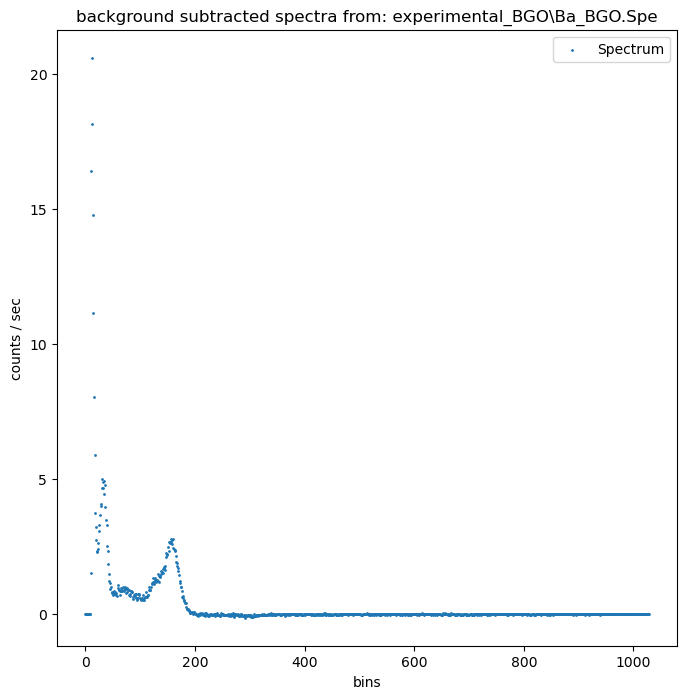

C:\Users\Bruce Ritter\AppData\Local\Temp\ipykernel_27460\1263951950.py:237: OptimizeWarning: Covariance of the parameters could not be estimated
  b_popt, b_pcov = curve_fit(quadratic, table["bins"][peak_range], background_y, p0 = None)


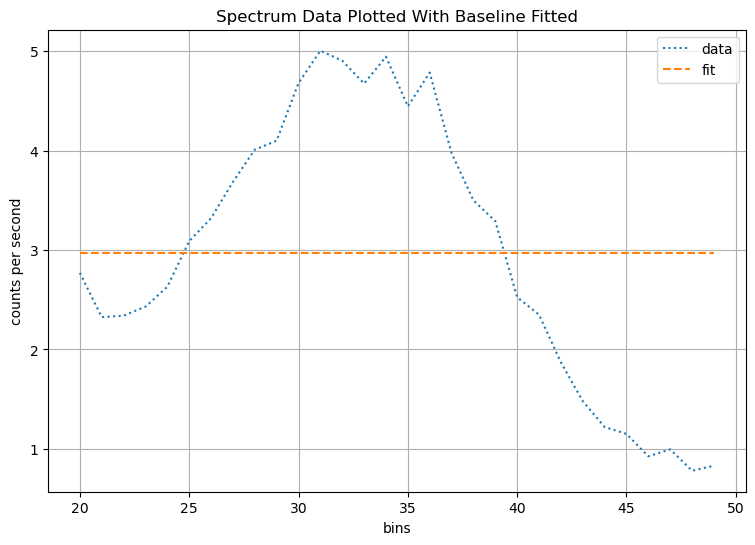

C:\Users\Bruce Ritter\AppData\Local\Temp\ipykernel_27460\1263951950.py:207: OptimizeWarning: Covariance of the parameters could not be estimated
  b_popt, b_pcov = curve_fit(quadratic, x, background_y, p0 = None)
C:\Users\Bruce Ritter\AppData\Local\Temp\ipykernel_27460\1263951950.py:210: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(compound_model, x, y, p0 = p0)


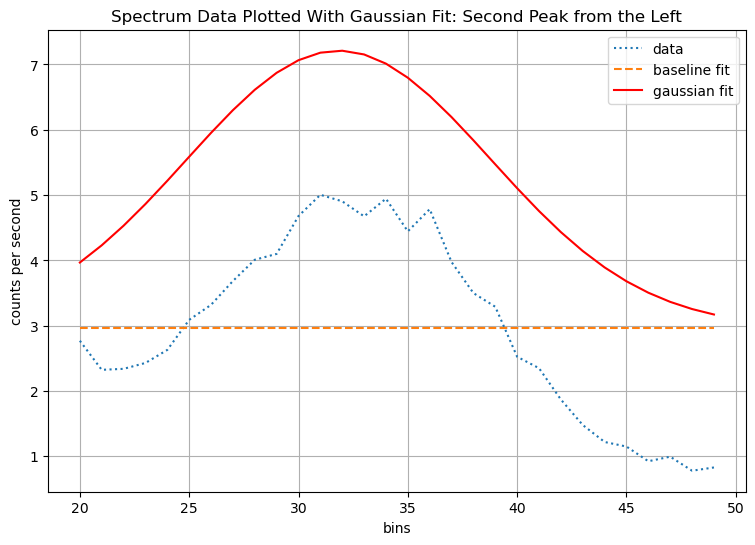

Parameters: 

Baseline Polynomial Fit: 
a = -1.1102230246251565e-15 +/- inf,
b = 7.30526750203353e-14 +/- inf, 
c = 0.6054548811648489 +/- inf
Gaussian Fit: 
mu0 = 31.84227017642773 +/- inf,
sigma0 = 6.965339518139601 +/- inf,
amp0 = 74.10169400769455 +/- inf


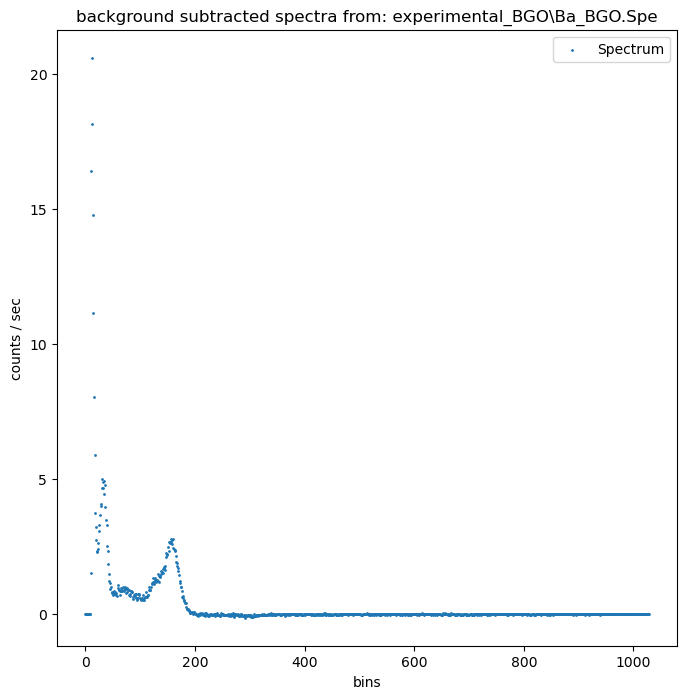

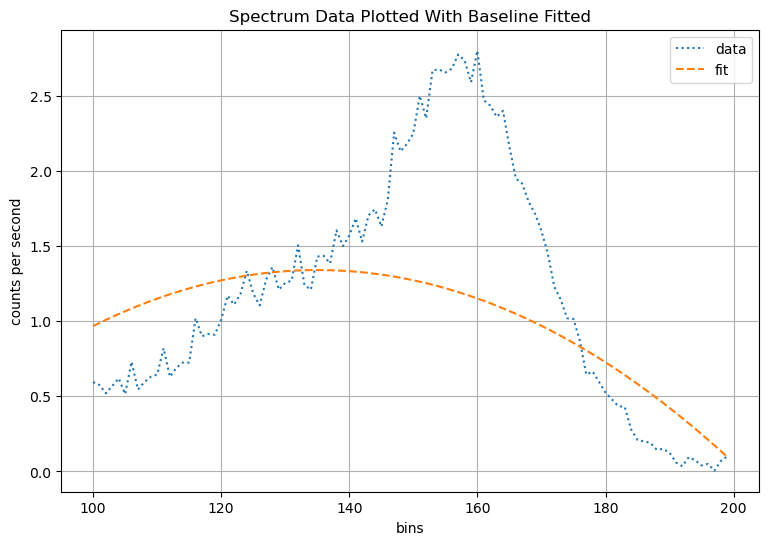

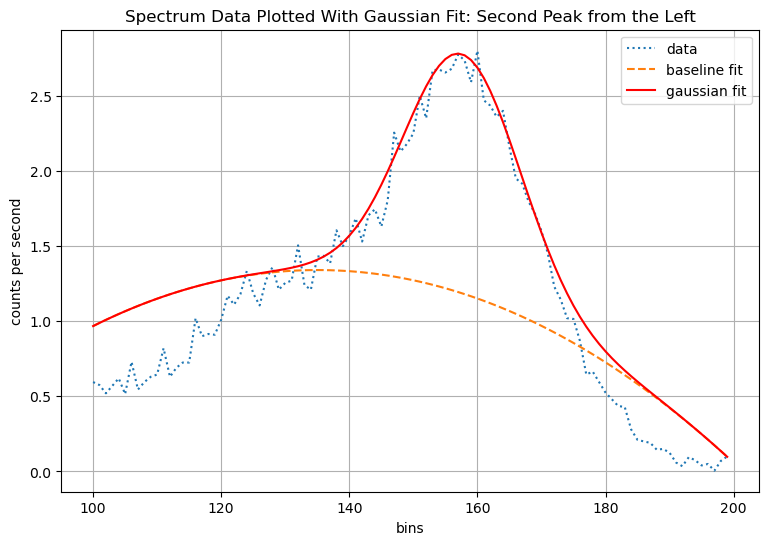

Parameters: 

Baseline Polynomial Fit: 
a = -0.00046330901603248184 +/- 2.7006162841247047e-05,
b = 0.13147336368930682 +/- 0.00821780445595851, 
c = -8.076799550372778 +/- 0.589047066790579
Gaussian Fit: 
mu0 = 157.61737677944632 +/- 0.25843154756464976,
sigma0 = 9.018744350522068 +/- 0.355247403289356,
amp0 = 35.96568596601065 +/- 1.9640172708760082


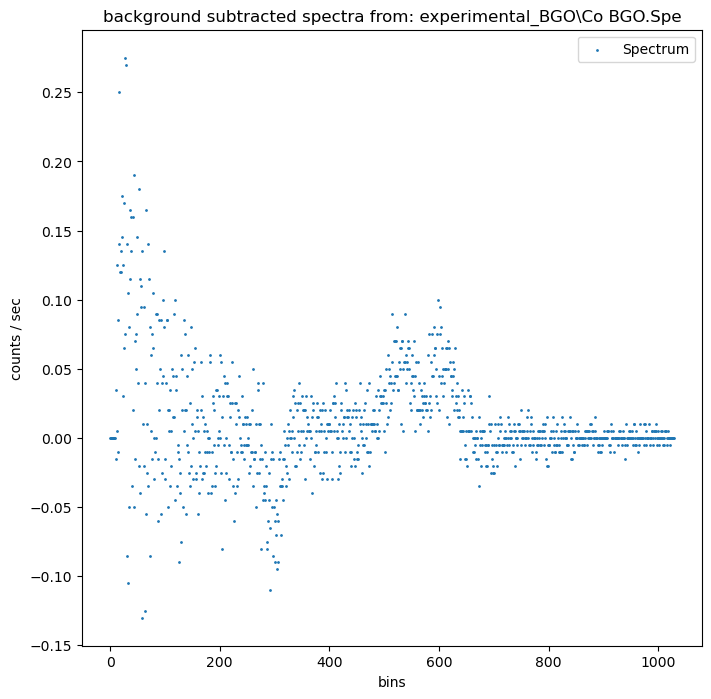

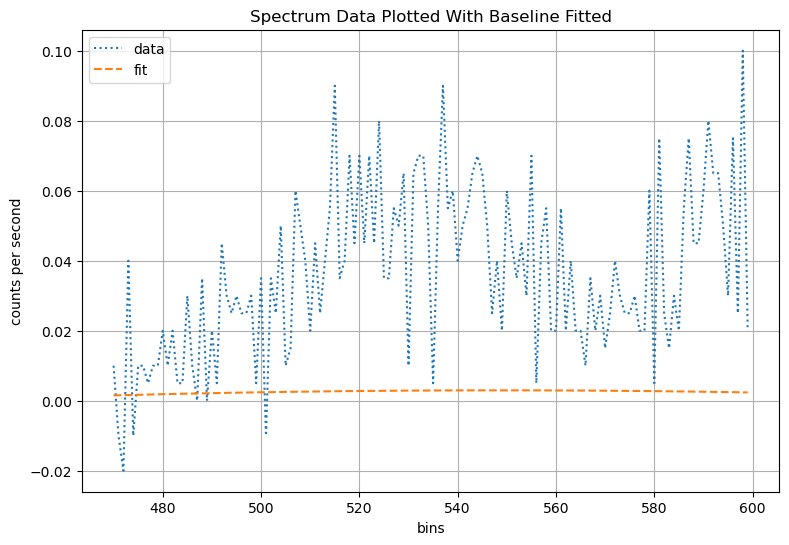

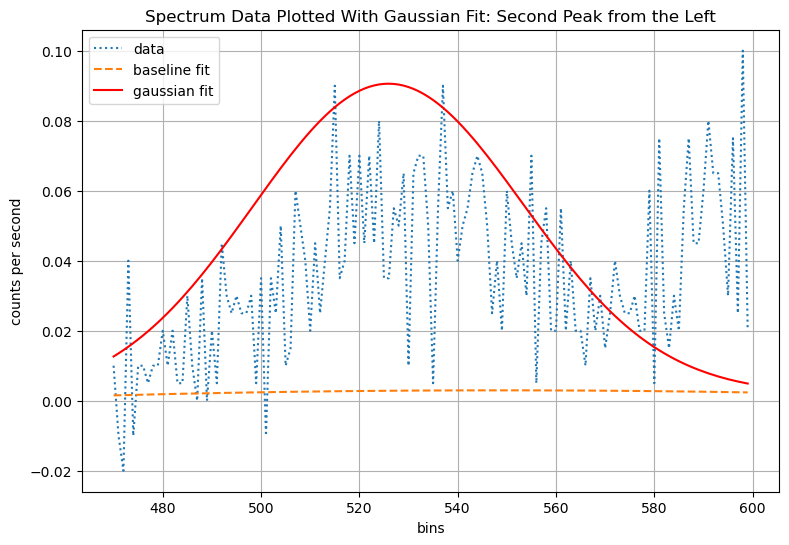

Parameters: 

Baseline Polynomial Fit: 
a = 1.4001611114890199e-05 +/- 1.091485729966894e-05,
b = -0.014487963101545074 +/- 0.01151950014473077, 
c = 3.714723063103304 +/- 2.9837302126541236
Gaussian Fit: 
mu0 = 525.8389178162998 +/- 2.231787585322703,
sigma0 = -27.473673087570653 +/- 8.833406504050231,
amp0 = 6.041577199899821 +/- 5.696844913291731


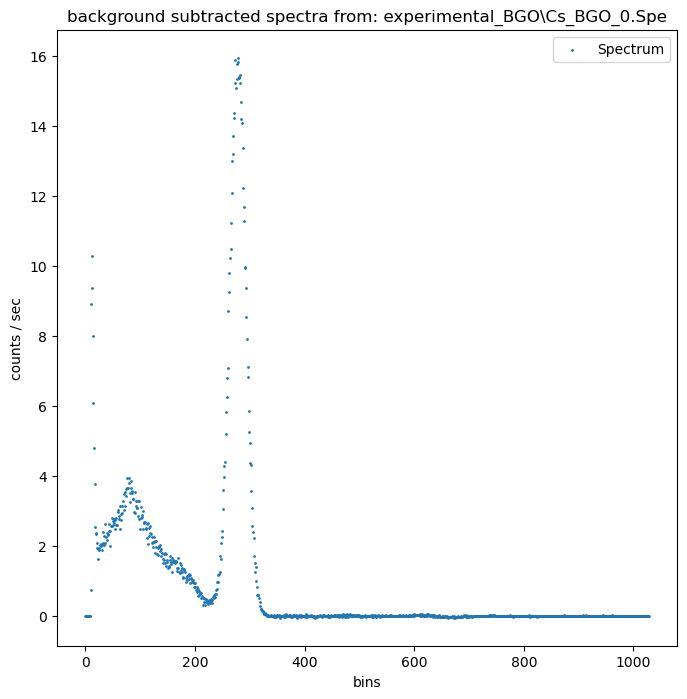

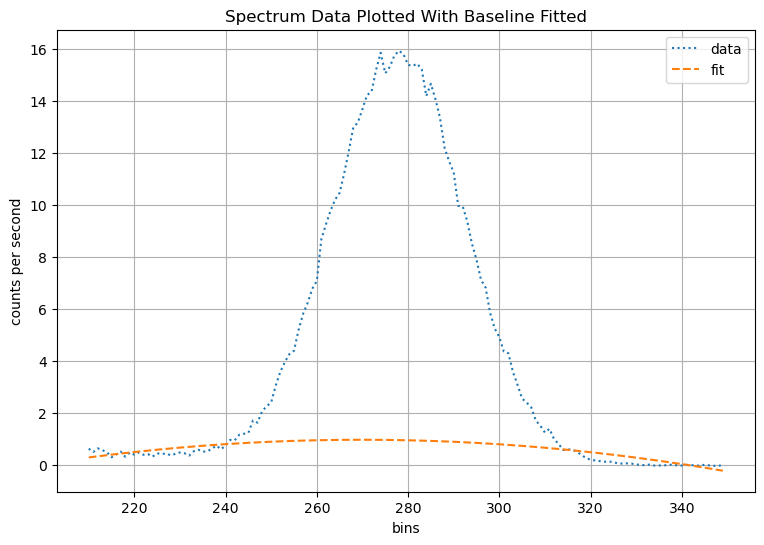

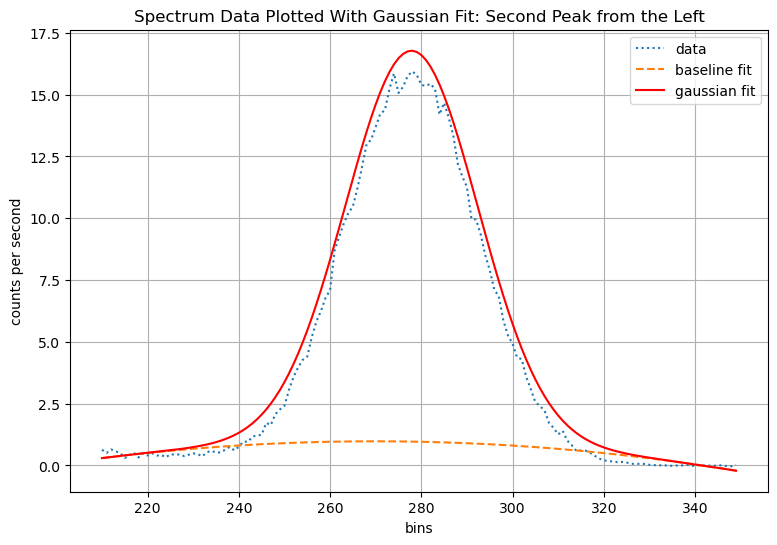

Parameters: 

Baseline Polynomial Fit: 
a = 4.125613262082229e-05 +/- 2.2939267127854018e-05,
b = -0.02668667659534502 +/- 0.012802239534056497, 
c = 4.311912033300172 +/- 1.7188162399974636
Gaussian Fit: 
mu0 = 277.89419245189106 +/- 0.049055533520809234,
sigma0 = 14.474561472628565 +/- 0.08081391877727791,
amp0 = 573.5945724977149 +/- 5.081515119699818


In [98]:
BGO_dict = make_results_dict("experimental_BGO/", "experimental_BGO/Buffer_BGO.Spe", "BGO")

In [99]:
BGO_dict

,energy,peak loc,FWHM,amp
0,80.9979,31.842270,16.403375,74.101694
1,356.0129,157.617377,21.239143,35.965686
2,1173.2280,525.838918,-64.700500,6.041577
3,661.6570,277.894192,34.087592,573.594572


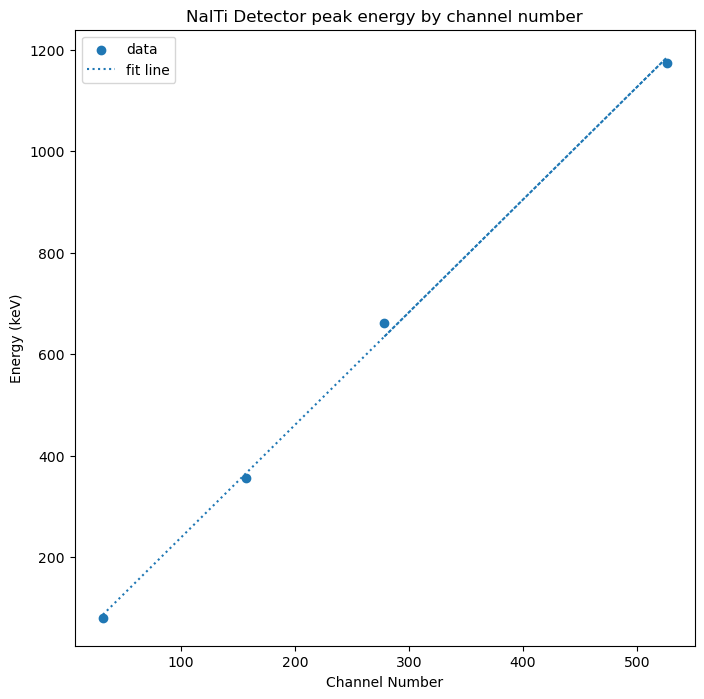

Slope: 2.2212574990748446 and Intercept: 16.439734589370815


In [100]:
slope, intercept = fit_energies(BGO_dict)

In [90]:
BGO_dict["FWHM (keV)"] = line(BGO_dict["FWHM"], slope, intercept)
BGO_dict

,energy,peak loc,FWHM,amp,FWHM (keV)
0,80.9979,31.842270,16.403375,74.101694,52.875853
1,356.0129,157.617377,21.239143,35.965686,63.617340
2,1173.2280,525.838918,-64.700500,6.041577,-127.276736
3,661.6570,277.894192,34.087592,573.594572,92.157055


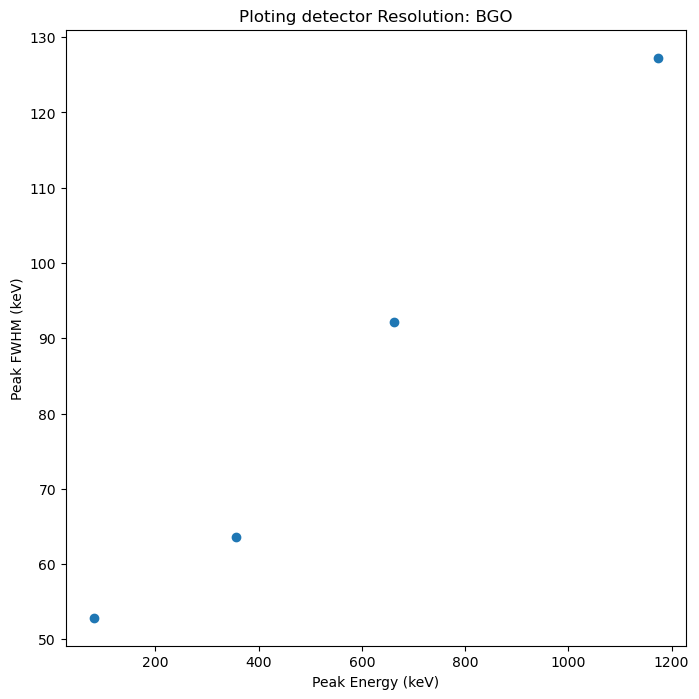

In [91]:
plt.close("all")
fig, ax = plt.subplots(figsize = (8,8))
ax.set_title("Ploting detector Resolution: BGO")
ax.set_xlabel("Peak Energy (keV)")
ax.set_ylabel("Peak FWHM (keV)")

ax.scatter(BGO_dict["energy"], np.abs(BGO_dict["FWHM (keV)"]))

plt.show()

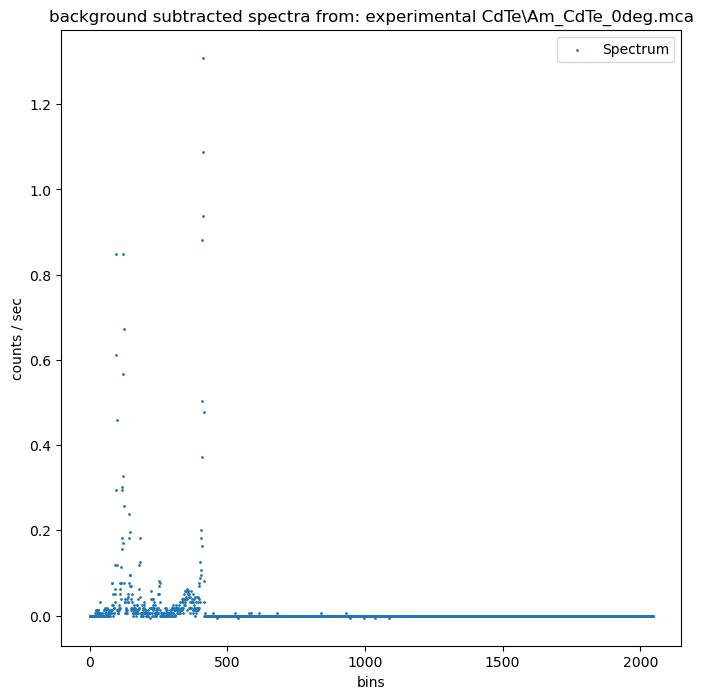

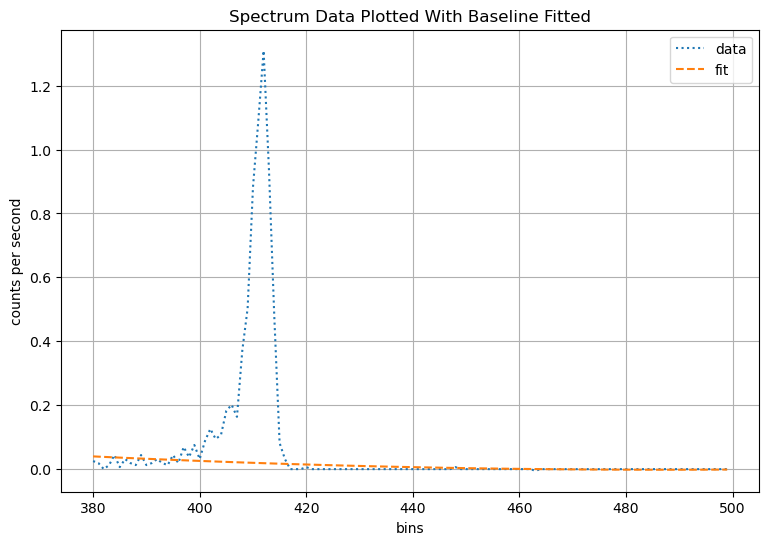

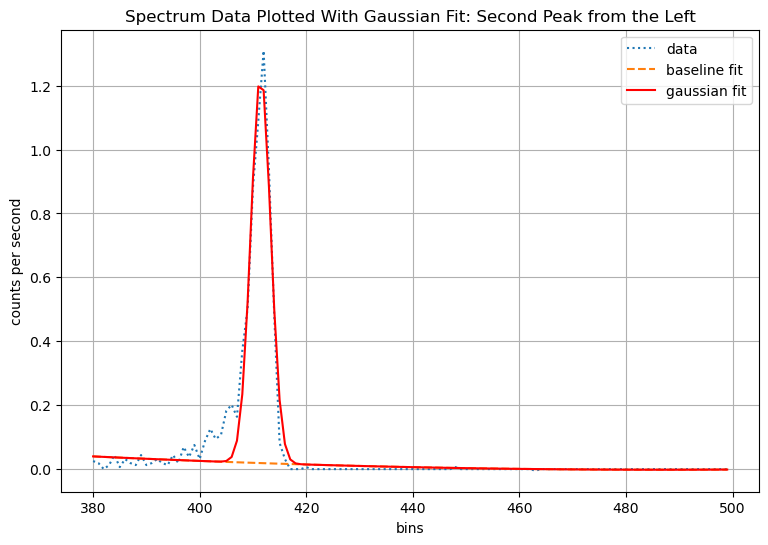

Parameters: 

Baseline Polynomial Fit: 
a = 4.87012039024162e-06 +/- 3.2687401707234156e-06,
b = -0.004716503555570716 +/- 0.0028721977853886343, 
c = 1.1394745667765056 +/- 0.6277537031956937
Gaussian Fit: 
mu0 = 411.46670808376376 +/- 0.04545043808178315,
sigma0 = -1.8580759504287385 +/- 0.04671203936471601,
amp0 = 5.663470521782035 +/- 0.12989319603202815


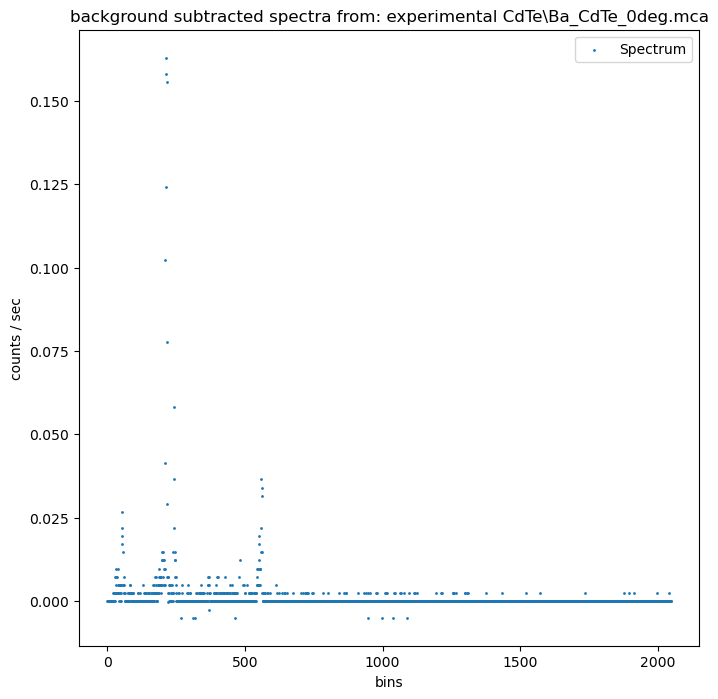

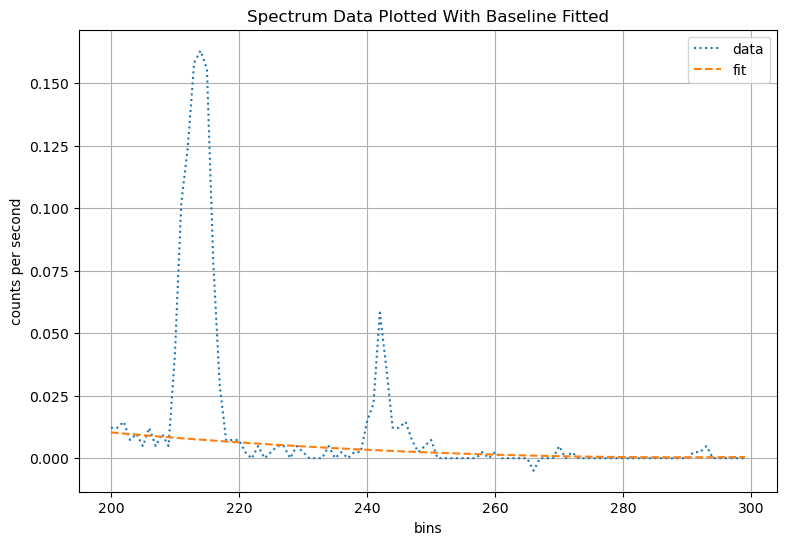

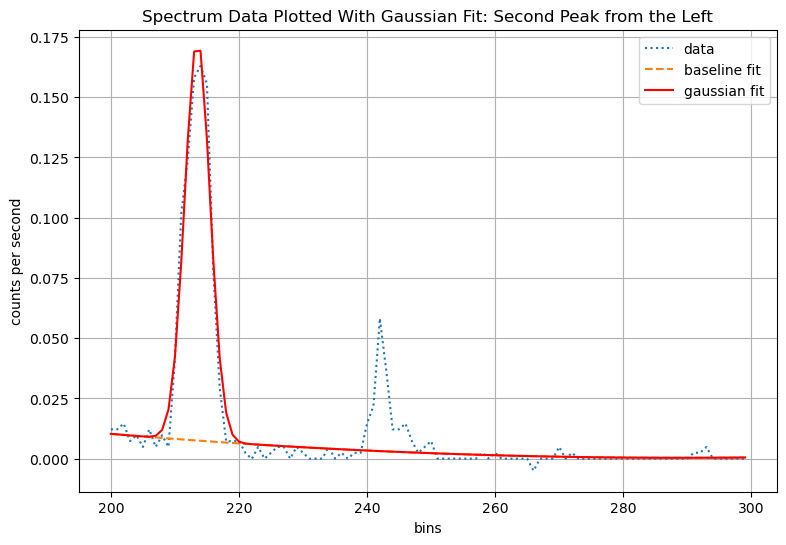

Parameters: 

Baseline Polynomial Fit: 
a = -4.5038431307942603e-07 +/- 1.193061361842409e-06,
b = 0.00013591971234315362 +/- 0.0005997795418868719, 
c = -0.0016012970441026957 +/- 0.07471214094567713
Gaussian Fit: 
mu0 = 213.5121303987218 +/- 0.07708734959678296,
sigma0 = 1.9673506219739474 +/- 0.08240841446908365,
amp0 = 0.8231751655758455 +/- 0.033507672772160726


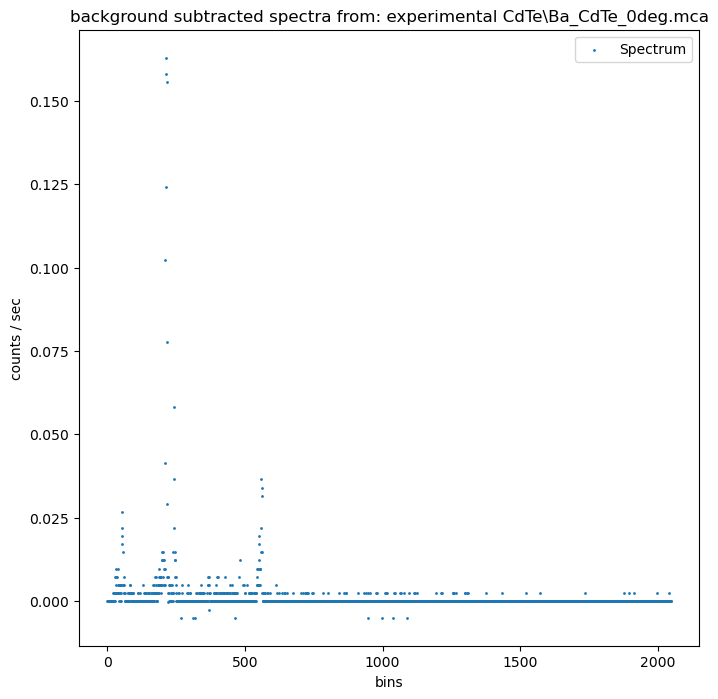

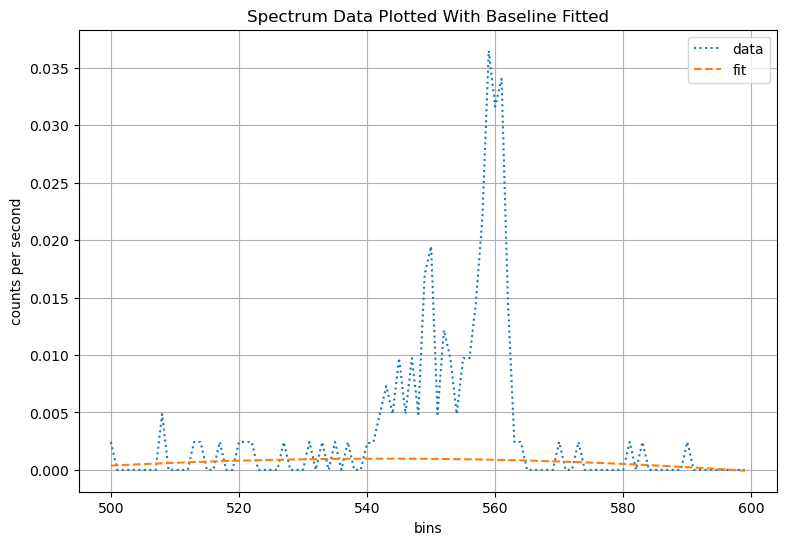

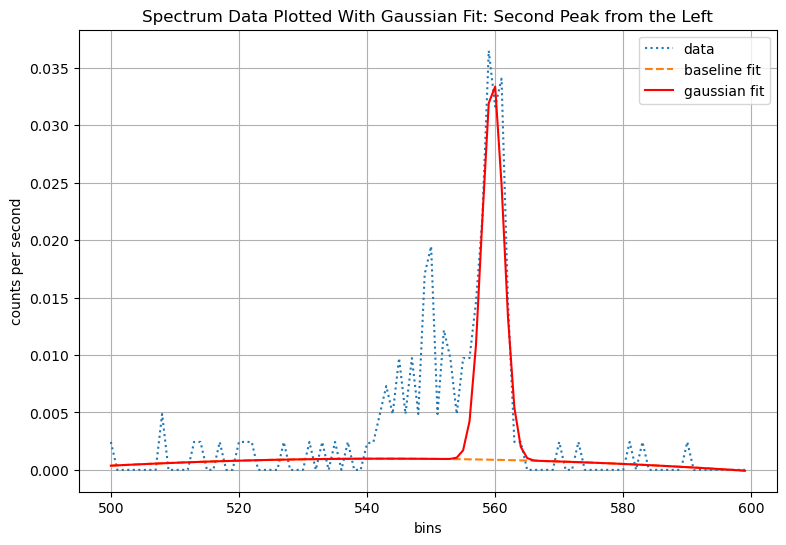

Parameters: 

Baseline Polynomial Fit: 
a = -2.150153950097934e-06 +/- 4.7125322646552035e-07,
b = 0.0023573509880846976 +/- 0.0005184490903638339, 
c = -0.6423151657339444 +/- 0.14223806088184646
Gaussian Fit: 
mu0 = 559.630694040932 +/- 0.13875424099543188,
sigma0 = -1.6904869728989331 +/- 0.14383806260470003,
amp0 = 0.14098038732196727 +/- 0.011102394701809546


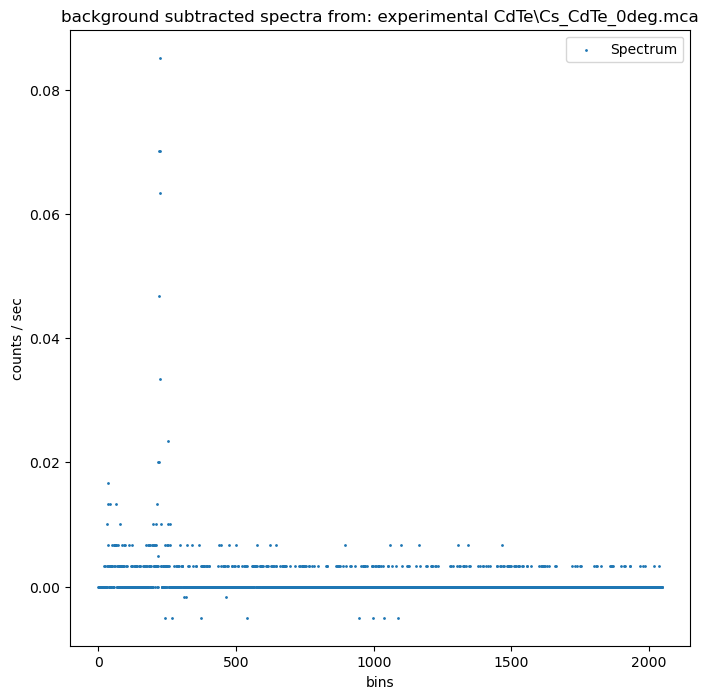

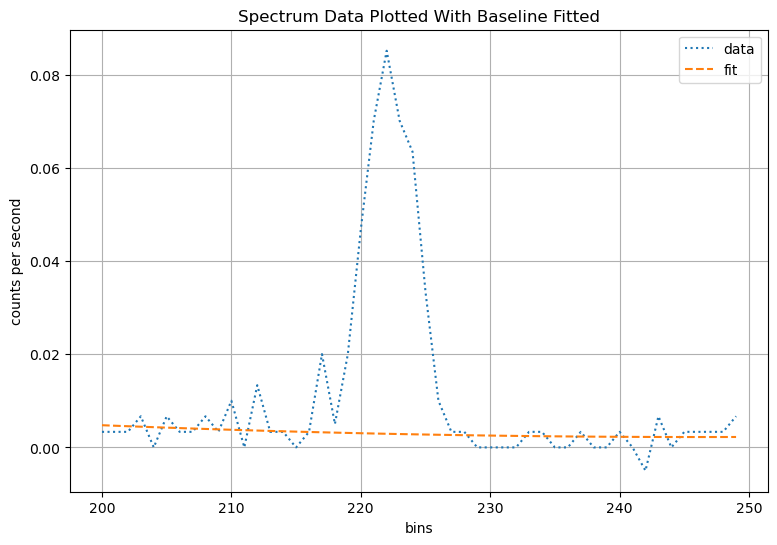

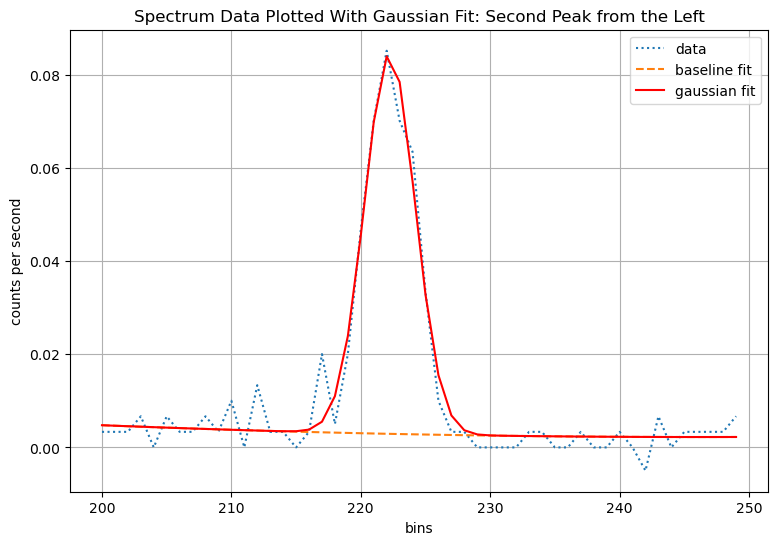

Parameters: 

Baseline Polynomial Fit: 
a = 3.6215906050097573e-06 +/- 3.7524210832281388e-06,
b = -0.0016932100883020908 +/- 0.0016833197422645265, 
c = 0.19962617469931254 +/- 0.1879245004333561
Gaussian Fit: 
mu0 = 222.23473685884932 +/- 0.07609156182859353,
sigma0 = -1.9558238286318201 +/- 0.08474449301484624,
amp0 = 0.3999513214481765 +/- 0.017948481966012803


In [101]:
CdTe_dict = make_results_dict("experimental CdTe/", "experimental CdTe/Buffer_CdTe.mca", "CdTe")

In [102]:
CdTe_dict

,energy,peak loc,FWHM,amp
0,59.5409,411.466708,-4.375769,5.663471
1,80.9979,213.512130,4.633111,0.823175
2,356.0129,559.630694,-3.981097,0.140980
3,661.6570,222.234737,-4.605965,0.399951


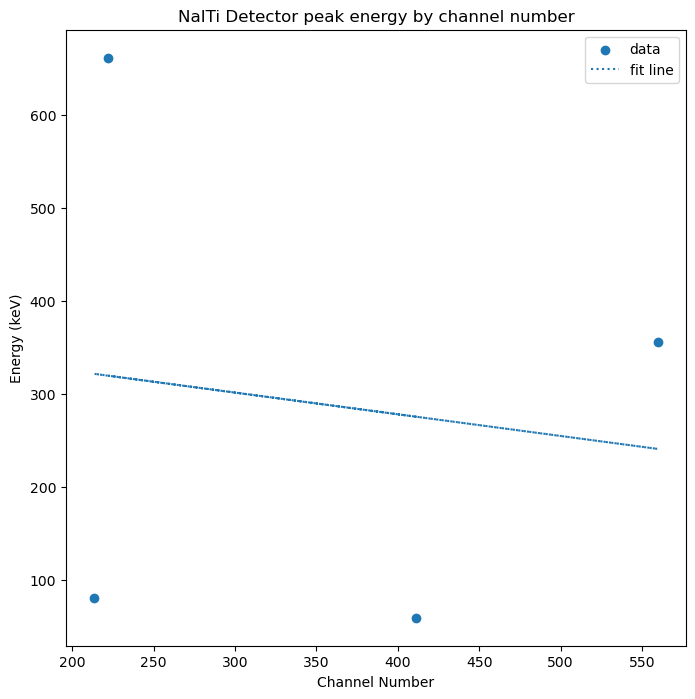

Slope: -0.23326579938436431 and Intercept: 371.59433809680775


In [103]:
slope, intercept = fit_energies(CdTe_dict)